## Demo notebook for accessing NSRDB data on Azure

This notebook provides an example of accessing National Solar Radiation Database (NSRDB) data from blob storage on Azure. The data is stored in one HDF file per year.

NSRDB data are stored in the East US Azure region, so this notebook will run most efficiently on Azure compute located in East US.  We recommend that substantial computation depending on NSRDB data also be situated in East US.  You don't want to download hundreds of terabytes to your laptop!  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This notebook was adapted from the [NREL NSRDB/HSDS example](https://github.com/NREL/hsds-examples/blob/master/notebooks/03_NSRDB_introduction.ipynb).

### Imports and constants

In [1]:
import xarray as xr
import pandas as pd
import planetary_computer

from adlfs import AzureBlobFileSystem

# Year to investigate and plot
year = 2015

# Storage resources
storage_account_name = 'nrel'
folder = f'nrel-nsrdb/v3'

### List the data files

We can use `adlfs` to list available files (one per year):

In [2]:
fs = AzureBlobFileSystem(
    account_name=storage_account_name,
    credential=planetary_computer.sas.get_token("nrel", "nrel-nsrdb").token
)
annual_files = fs.glob(folder + '/*.h5')
print('Found {} annual files:'.format(len(annual_files)))
for path in annual_files[:10]:
    print(path)

print('...')

Found 23 annual files:
nrel-nsrdb/v3/nsrdb_1998.h5
nrel-nsrdb/v3/nsrdb_1999.h5
nrel-nsrdb/v3/nsrdb_2000.h5
nrel-nsrdb/v3/nsrdb_2001.h5
nrel-nsrdb/v3/nsrdb_2002.h5
nrel-nsrdb/v3/nsrdb_2003.h5
nrel-nsrdb/v3/nsrdb_2004.h5
nrel-nsrdb/v3/nsrdb_2005.h5
nrel-nsrdb/v3/nsrdb_2006.h5
nrel-nsrdb/v3/nsrdb_2007.h5
...


### Open one data file with xarray

In [3]:
file = fs.open(f"nrel-nsrdb/v3/nsrdb_{year}.h5")
ds = xr.open_dataset(file, backend_kwargs={"phony_dims": "sort"}, engine="h5netcdf")
ds

<xarray.Dataset>
Dimensions:                   (phony_dim_0: 17520, phony_dim_1: 2018392,
                               phony_dim_2: 2)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2
Data variables: (12/28)
    air_temperature           (phony_dim_0, phony_dim_1) int8 ...
    alpha                     (phony_dim_0, phony_dim_1) int16 ...
    aod                       (phony_dim_0, phony_dim_1) int16 ...
    asymmetry                 (phony_dim_0, phony_dim_1) int16 ...
    cld_opd_dcomp             (phony_dim_0, phony_dim_1) int16 ...
    cld_reff_dcomp            (phony_dim_0, phony_dim_1) int16 ...
    ...                        ...
    surface_albedo            (phony_dim_0, phony_dim_1) int16 ...
    surface_pressure          (phony_dim_0, phony_dim_1) int16 ...
    time_index                (phony_dim_0) |S30 ...
    total_precipitable_water  (phony_dim_0, phony_dim_1) int16 ...
    wind_direction            (phony_dim_0, phony_dim_1) int16 ...
    wind_speed                (phony_dim_0, phony_dim_1) int16 ...
Attributes:
    Version:  3.0.6

### Explore metadata

In [4]:
# Datasets are stored in 2D grids of size [time x location]
dset = ds['ghi']
dset.shape

(17520, 2018392)

In [5]:
# Extract datetime index for datasets
time_index = pd.to_datetime(ds['time_index'][...].astype(str))
time_index # temporal resolution is 30min

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 00:30:00',
               '2015-01-01 01:00:00', '2015-01-01 01:30:00',
               '2015-01-01 02:00:00', '2015-01-01 02:30:00',
               '2015-01-01 03:00:00', '2015-01-01 03:30:00',
               '2015-01-01 04:00:00', '2015-01-01 04:30:00',
               ...
               '2015-12-31 19:00:00', '2015-12-31 19:30:00',
               '2015-12-31 20:00:00', '2015-12-31 20:30:00',
               '2015-12-31 21:00:00', '2015-12-31 21:30:00',
               '2015-12-31 22:00:00', '2015-12-31 22:30:00',
               '2015-12-31 23:00:00', '2015-12-31 23:30:00'],
              dtype='datetime64[ns]', length=17520, freq=None)

In [6]:
# Location information is stored in either 'meta' or 'coordinates'
meta = ds['meta']

# Each element contains values for, e.g., latitude, longitude, elevation, and land cover type
print(meta)

<xarray.DataArray 'meta' (phony_dim_1: 2018392)>
[2018392 values with dtype=[('latitude', '<f4'), ('longitude', '<f4'), ('elevation', '<f4'), ('timezone', '<i2'), ('country', 'S30'), ('state', 'S30'), ('county', 'S30'), ('urban', 'S30'), ('population', '<i4'), ('landcover', '<i2')]]
Dimensions without coordinates: phony_dim_1
Attributes:
    country_fill_value:     None
    county_fill_value:      None
    elevation_units:        meters
    landcover_fill_value:   -9999
    landcover_types:        11: Post-flooding or irrigated croplands (or aqua...
    lat_units:              decimal degrees
    lng_units:              decimal degrees
    population_fill_value:  -9999
    state_fill_value:       None
    timezone_fill_value:    -9999
    timezone_units:         UTC Offset
    urban_fill_value:       None


### Extract a subset of the data

In [7]:
# find the position where time_index is this value
timestep = time_index.get_loc(pd.Timestamp(str(year) + "-12-31 19:00:00"))

# capture metadata in a pandas dataframe
meta = ds["meta"].data
df = pd.DataFrame(meta) 

# find the positions where df['state'] is California
CA = df[df["state"] == b"California"]

# load a subset of that data
subset = ds["ghi"][timestep, CA.index].load()

### Plot that subset

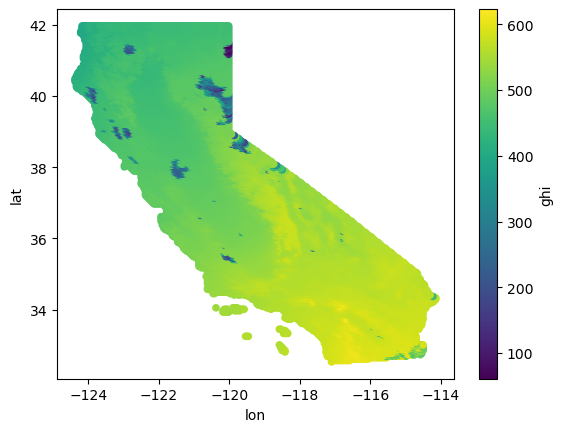

In [8]:
p = pd.DataFrame({"ghi": subset, "lat": CA.latitude, "lon": CA.longitude}).plot.scatter(x="lon", y="lat", c="ghi", cmap="viridis")